<a href="https://colab.research.google.com/github/berkantbayraktar/Temperature-Prediction-w-LSTM/blob/master/CENG501_Spring2021_PA3_Task_temperature_prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Sequence Modeling Pipeline with PyTorch for Weather Prediction
# CENG501 - Spring 2021 - PA3

In this task, you are expected to experience and demonstrate a pipeline for training a recurrent network.

## 1 Import Modules

In [1]:
import torch
import torch.nn as nn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable 
from sklearn.preprocessing import MinMaxScaler

## 2 Dataset

We will use the hourly temperature data for Basel (why Basel? because it was freely available) from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) between 1 June 2021 and 23 June 2021. Here is a description of how you should prepare your dataset from this raw file:

* Raw data is available [here](http://kovan.ceng.metu.edu.tr/~sinan/DL/Basel_weather.xlsx) as an XLSX file which was downloaded from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30).

* Load the file into Python as a NumPy array using [Pandas](https://pp4e-book.github.io/chapters/ch10_scientific_libraries.html#data-handling-analysis-with-pandas). Filter out unnecessary information at the top and convert the first column to an hour index, starting at 0 and finishing at 551.

* Split the data into two: A training set from the values between 1 June 2021 and 16 June 2021 (inclusive). A test set from the remaining values.

* For each set, slide a time window of six hours and with a stride of 1, and for each position of the window, create a training input-output pair as follows:

  $(\mathbf{x}_i = <T_i, T_{i+1}, T_{i+2}, T_{i+3}, T_{i+4}>, y_i = T_{i+5}),$
 
  where $T_i$ is the temperature at hour index $i$. 


In [2]:
# Load the dataset.
df = pd.read_csv("data/Basel_weather.csv")

In [3]:
# Clean the dataset
df = df[9:]
df.reset_index(drop=True, inplace=True)
df = df.rename(columns={'location': 'time', 'Basel': 'temperature'})
df = df.astype({'temperature': float})

In [4]:
# Split the dataset
train_df = df[:360]
test_df = df[360:]

In [5]:
train_df.tail()

,time,temperature
355,20210615T1900,28.970530
356,20210615T2000,28.260529
357,20210615T2100,27.060530
358,20210615T2200,25.770529
359,20210615T2300,24.240528


In [6]:
test_df.tail()

,time,temperature
547,20210623T1900,20.850529
548,20210623T2000,18.860529
549,20210623T2100,17.820530
550,20210623T2200,17.190529
551,20210623T2300,16.560530


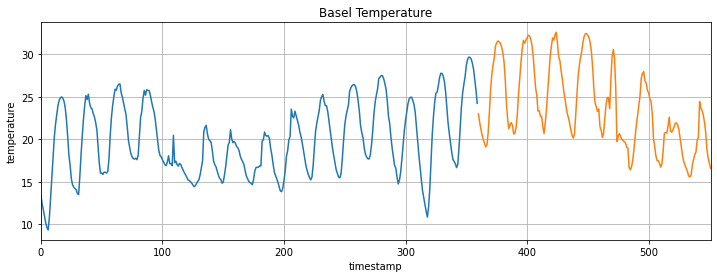

In [7]:
plt.figure(figsize=(12,4))
plt.title('Basel Temperature')
plt.ylabel('temperature')
plt.xlabel('timestamp')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(train_df['temperature'])
plt.plot(test_df['temperature'])
plt.show()

In [8]:
y_train = train_df['temperature'].values.astype(float)
y_test = test_df['temperature'].values.astype(float)

In [9]:
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
# Normalize the training set
train_norm = scaler.fit_transform(y_train.reshape(-1, 1))

In [10]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

In [11]:
def generate_data(seq, ws=6):
    data = []
    for i in range(len(seq) - ws):
        xi = seq[i:i+ws]
        yi = seq[i+ws:i+ws+1]
        data.append((xi,yi))
    return data
    

In [12]:
train_data = generate_data(train_norm)
print("len train_data : ", len(train_data))

len train_data :  354


In [13]:
train_data[353]

(tensor([0.9980, 0.9774, 0.9303, 0.8606, 0.7428, 0.6161]), tensor([0.4659]))

In [14]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 4 Your Sequence Model

In [15]:
class MyWeatherPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MyWeatherPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_dim),
                       torch.zeros(1,1,self.hidden_dim))
 
 
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## 5 Your Trainer

Implement your training function here. You can use functions we have defined in the previous assignments.

In [16]:
model = MyWeatherPredictor(1, 100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

MyWeatherPredictor(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## 6 Train Your Model

Create an instance of your model, a suitable loss function, a suitable optimizer and call the training function with suitable hyperparameters (learning rate, batch size, hidden size etc.).

In [18]:
len(y_test)

192

In [19]:
epochs = 300
loss_values = []
start_time = time.time()
for i in range(epochs):
    
    # tuple-unpack the train_data set
    for seq, gt in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1,1,model.hidden_dim),
                        torch.zeros(1,1,model.hidden_dim))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, gt)   
        loss.backward()       
        optimizer.step()
        
    loss_values.append(loss.item())
    # print training result
    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch: 10 Loss: 0.01254495
Epoch: 20 Loss: 0.01002393
Epoch: 30 Loss: 0.00401283
Epoch: 40 Loss: 0.00107870
Epoch: 50 Loss: 0.00011630
Epoch: 60 Loss: 0.00033253
Epoch: 70 Loss: 0.00065818
Epoch: 80 Loss: 0.00004596
Epoch: 90 Loss: 0.00000512
Epoch: 100 Loss: 0.00002442
Epoch: 110 Loss: 0.00002260
Epoch: 120 Loss: 0.00001565
Epoch: 130 Loss: 0.00001583
Epoch: 140 Loss: 0.00002970
Epoch: 150 Loss: 0.00002496
Epoch: 160 Loss: 0.00000161
Epoch: 170 Loss: 0.00000500
Epoch: 180 Loss: 0.00041930
Epoch: 190 Loss: 0.00015694
Epoch: 200 Loss: 0.00000060
Epoch: 210 Loss: 0.00000282
Epoch: 220 Loss: 0.00000032
Epoch: 230 Loss: 0.00021481
Epoch: 240 Loss: 0.00000670
Epoch: 250 Loss: 0.00003698
Epoch: 260 Loss: 0.00037340
Epoch: 270 Loss: 0.00000323
Epoch: 280 Loss: 0.00002643
Epoch: 290 Loss: 0.00001039
Epoch: 300 Loss: 0.00012161

Duration: 144 seconds


## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

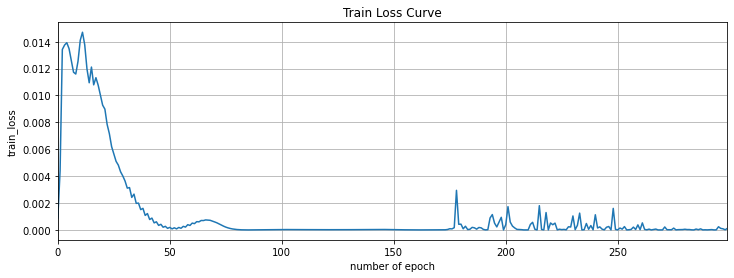

In [20]:
plt.figure(figsize=(12,4))
plt.title('Train Loss Curve')
plt.ylabel('train_loss')
plt.xlabel('number of epoch')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(loss_values)
plt.show()

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

### 7.3 Qualitative Analysis

Plot test data and your predictions over a sliding window. Plot two versions of your predictions: (i) Window sliding on the test data and you plot the predictions only. (ii) After obtaining the first prediction on the test data, window sliding over the predictions.

In [22]:
future = len(y_test)
window_size = 6
# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_dim),
                        torch.zeros(1,1,model.hidden_dim))
        preds.append(model(seq).item())

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
len(true_predictions)

192

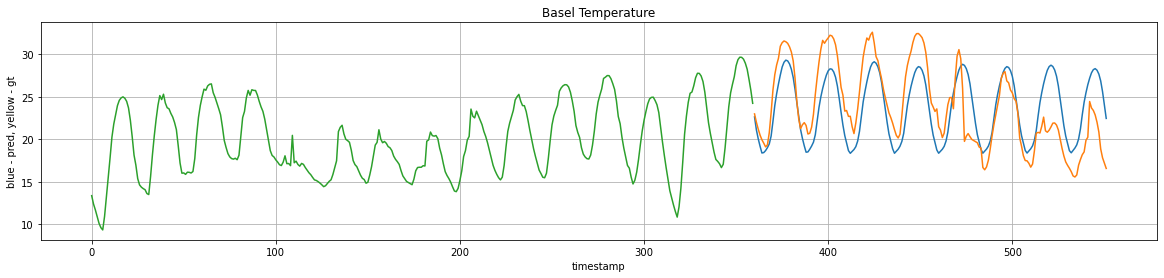

In [24]:
plt.figure(figsize=(20,4))
plt.title('Basel Temperature')
plt.ylabel('blue - pred, yellow - gt')
plt.xlabel('timestamp')
plt.grid(True)
plt.autoscale(axis='x')
plt.plot(range(360,360 + 192), true_predictions)
plt.plot(range(360,360 + 192), y_test[:future].reshape(-1,1))
plt.plot(range(0,360),train_df['temperature'])
plt.show()

In [25]:
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
# Normalize the training set
test_norm = scaler.fit_transform(y_test.reshape(-1, 1))

In [26]:
# Convert train_norm from an array to a tensor
test_norm = torch.FloatTensor(test_norm).view(-1)

In [27]:
window_size = 6
future = len(y_test) - window_size - 1 

# Add the last window of training values to the list of predictions
inputs = test_norm[:window_size].tolist()
preds = []
# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(inputs[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_dim),
                        torch.zeros(1,1,model.hidden_dim))
        inputs.append(test_norm[window_size + i ])
        preds.append(model(seq).item())

In [28]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

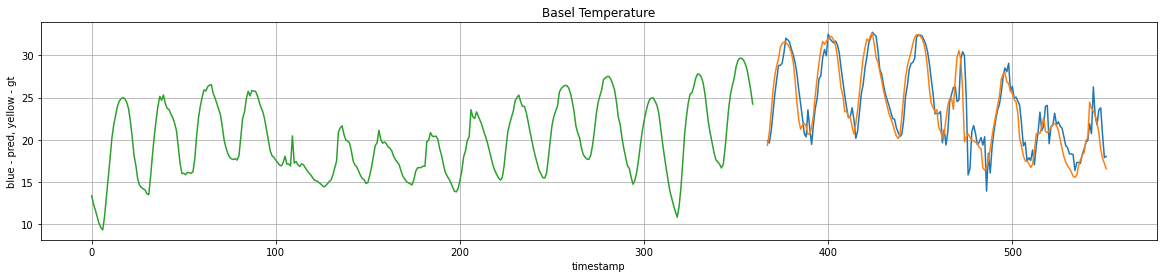

In [29]:
plt.figure(figsize=(20,4))
plt.title('Basel Temperature')
plt.ylabel('blue - pred, yellow - gt')
plt.xlabel('timestamp')
plt.grid(True)
plt.autoscale(axis='x')
plt.plot(range(360 + window_size +1 ,360 + 192), true_predictions)
plt.plot(range(360 + window_size +1 ,360 + 192), y_test[window_size+1:].reshape(-1,1))
plt.plot(range(0,360),train_df['temperature'])
plt.show()

## 8 Tune Your Model

Tune the following aspects for your model and provide a figure or a table in each case:

- Number of hidden neurons.
- Learning rate.
- Batch size.

Report the performance of the best model after tuning.

In [30]:
# number of hidden neurons = 100
# learning rate = 0.001
# batch_size = 1
# epoch = 300